<h1 style="text-align: center;"> EE6310 - IMAGE AND VIDEO PROCESSING - ASSIGNMENT 5</h1>
<h2 style="text-align: right;">  ATHARV RAMESH NAIR <br>EE20BTECH11006</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<h2 style="text-align: center;"> 1. PRINCIPLE COMPONENT ANALYSIS</h2>


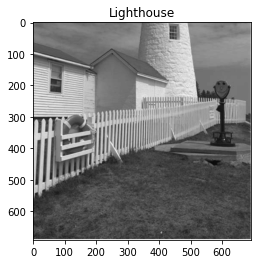

In [2]:
I = plt.imread('lighthouse.png')
plt.rcParams["figure.figsize"] = (5,5)
I = (I[:,:,0]*255).astype('uint8')
imgplot = plt.imshow(I,cmap = 'gray')
plt.title('Lighthouse')
plt.show()

### Function to compress the image using PCA
### The function returns the compressed data as well as the reconstructed image

In [3]:
def PCA_compression(img,num_components):
 
    # img is the input image
    # num_components is the number of principal components to be used for compression
    # returns the compressed image
    N,M = img.shape
    vec_block = []
    for i in range(0,N,8):
        for j in range(0,M,8):
            vec_block.append(I[i:i+8,j:j+8].reshape(64))
    vec_block = np.array(vec_block)
    vec_block = vec_block.T
    mean = np.mean(vec_block,axis = 0)
    vec_block = vec_block - mean

    cov = (1/64)*np.cov(vec_block)/64

    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    compressed_data = np.dot(sorted_eigenvectors[:, :num_components].T, vec_block) 

    reconstructed_data = np.dot(sorted_eigenvectors[:, :num_components], compressed_data) + mean
    
    reconstructed_img = np.zeros((N,M))
    for i in range(0,N,8):
        for j in range(0,M,8):
            reconstructed_img[i:i+8,j:j+8] = reconstructed_data[:,i//8*86+j//8].reshape(8,8)
    return compressed_data,reconstructed_img

In [4]:
I = I[:688,:688]
compressed_data ,compressed_img_48 = PCA_compression(I,48)
compressed_data ,compressed_img_32 = PCA_compression(I,32)
compressed_data ,compressed_img_16 = PCA_compression(I,16)


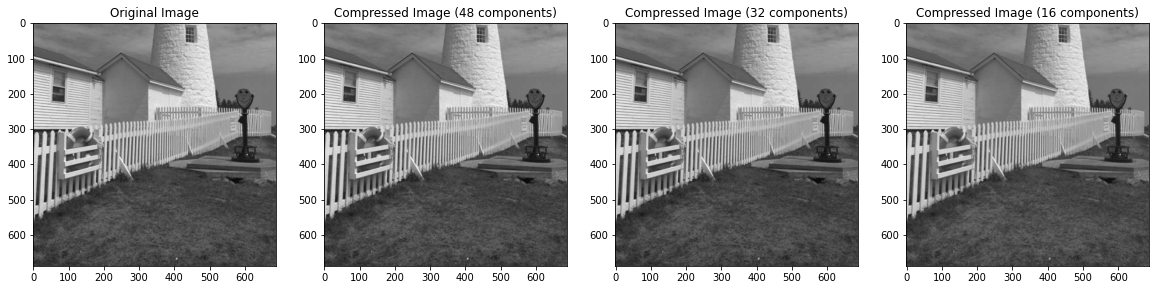

In [5]:
plt.rcParams["figure.figsize"] = (20 ,10)
plt.subplot(1,4,1)
plt.imshow(I,cmap = 'gray')
plt.title('Original Image')
plt.subplot(1,4,2)
plt.imshow(compressed_img_48,cmap = 'gray')
plt.title('Compressed Image (48 components)')
plt.subplot(1,4,3)
plt.imshow(compressed_img_32,cmap = 'gray')
plt.title('Compressed Image (32 components)')
plt.subplot(1,4,4)
plt.imshow(compressed_img_16,cmap = 'gray')
plt.title('Compressed Image (16 components)')
plt.show()

<h4 style = "text-align : center";> As reduce the number of components, the image quality reduces. But despite this , the compressed image 
with 16 components is very much recognisable </h4>

<h2 style="text-align: center;"> 2. DISCRETE COSINE TRANSFORM</h2>


### Function to perform DCT

### DCT Matrix Generation

In [6]:
def DCT_matrix(N):
    # N is the size of the DCT matrix
    # returns the DCT matrix
    dct = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i == 0:
                dct[i,j] = np.sqrt(1/N)
            else:
                dct[i,j] = np.sqrt(2/N)*np.cos(((2*j+1)*i*np.pi)/(2*N))
    return dct

### Functions to compute DCT and IDCT

In [7]:
def DCT_2(img):
    # img is the input image
    # returns the DCT coefficients of the image
    N = img.shape[0]
    dct = DCT_matrix(N)
    dct_coeff = dct @ img @ dct.T
    return dct_coeff

def IDCT_2(dct_coeff):
    # dct_coeff is the DCT coefficients of the image
    # returns the reconstructed image
    N = dct_coeff.shape[0]
    dct = DCT_matrix(N)
    img = dct.T @ dct_coeff @ dct
    return img

### Quantization Matrix

In [8]:
Q_matrix  = np.array([[16,11,10,16,24,40,51,61],
                      [12,12,14,19,26,58,60,55],
                      [14,13,16,24,40,57,69,56],
                      [14,17,22,29,51,87,80,62],
                      [18,22,37,56,68,109,103,77],
                      [24,35,55,64,81,104,113,92],
                      [49,64,78,87,103,121,120,101],
                      [72,92,95,98,112,100,103,99]])

### Function to compress the image using DCT and Q_matrix

In [9]:
def DCT_compresss(img):
    M,N = img.shape
    DCT_img = np.zeros((M,N))
    for i in range(0,M,8):
        for j in range(0,N,8):
            DCT_img[i:i+8,j:j+8] = DCT_2(img[i:i+8,j:j+8])/Q_matrix + 0.5   

    DCT_img = DCT_img.astype('int32')


    return DCT_img

### Image Reconstruction 

In [10]:
def DCT_reconstruct(compressed_img):
    M,N = compressed_img.shape
    reconstructed_img = np.zeros((M,N),dtype=np.float32)

    for i in range(0,M,8):
        for j in range(0,N,8):
            reconstructed_img[i:i+8,j:j+8] = IDCT_2(compressed_img[i:i+8,j:j+8]*Q_matrix)

    return reconstructed_img

In [11]:
compressed_img = DCT_compresss(I)
reconstructed_img = DCT_reconstruct(compressed_img)

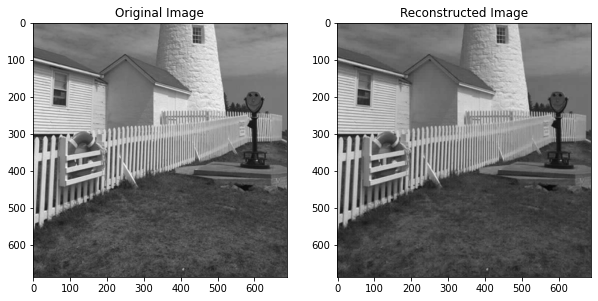

In [12]:
plt.rcParams["figure.figsize"] = (10 ,10)
plt.subplot(1,2,1)
plt.imshow(I,cmap = 'gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(reconstructed_img,cmap = 'gray')
plt.title('Reconstructed Image')
plt.show()

<h4 style = "text-align : center";> The number of non-zero components gives us a good estimate of how good the compression is</h4>

In [13]:
non_zero_count = np.count_nonzero(compressed_img)/(I.shape[0]*I.shape[1])
print(f'Percentage of Non Zero Values in the compressed image =  {non_zero_count*100} %')

Percentage of Non Zero Values in the compressed image =  8.97761458896701 %


<h4 style = "text-align : center";> DCT-based compression is very effective. The above reconstructed_img is as good as the original image visually</h4>

<h4 style = "text-align : center";> In fact, we can achieve much higher compression. If we increase the value of Q_matrix </h4>

In [14]:
Q_matrix = (5*Q_matrix).astype('int32')
compressed_img_5 = DCT_compresss(I)
reconstructed_img_5 = DCT_reconstruct(compressed_img)

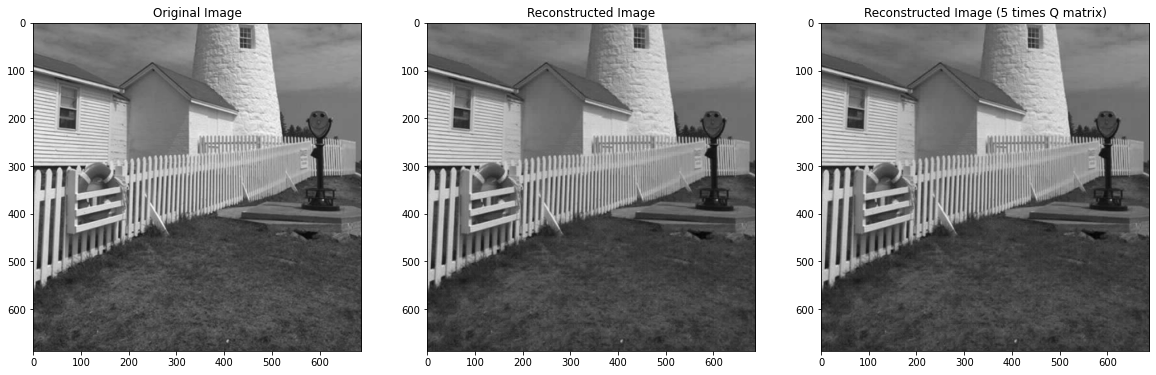

In [15]:
plt.rcParams["figure.figsize"] = (20 ,10)
plt.subplot(1,3,1)
plt.imshow(I,cmap = 'gray')
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(reconstructed_img,cmap = 'gray')
plt.title('Reconstructed Image')
plt.subplot(1,3,3)
plt.imshow(reconstructed_img_5,cmap = 'gray')
plt.title('Reconstructed Image (5 times Q matrix)')

plt.show()

<h4 style = "text-align : center";> The image on the right seems more blocky but still it is a good reconstruction </h4>